In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=3d9327a74e140cd2085c2af4c0ac4708880539deaea0bfbcef81a0683d012e90
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


# Importer les bibliothèques nécessaires

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate, ZGate


import os, sys
sys.path.append(os.getcwd())

In [3]:
# This for Google Colab, so that we can import the files from the repository
!git clone https://github.com/algolab-quantique/IMACA-CMAI-Grover.git

sys.path.insert(0,'/content/IMACA-CMAI-Grover')

Cloning into 'IMACA-CMAI-Grover'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 40 (delta 20), reused 13 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (40/40), 11.14 MiB | 10.98 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [4]:
# Import the utils functions from the repository
from utils import get_disjunction_control_state, get_disjunction_qubits

# Les sept clauses du problème de Pincus

Une clause de la forme

$
    (x_0 \lor x_2 \lor \neg x_3)
$

est écrite :
```
clause = {'x0' : True, 'x2' : True, 'x3' : False}
````

Rappel :

* x0 = Peureux
* x1 = Heureux
* x2 = Malade
* x3 = Bruyant


In [37]:
clauses = []

d = 'x0'
c = 'x1'
l = 'x2'
f = 'x3'
o = 'x4'

# c1
clauses.append({d : False, f : False})

# c2
clauses.append({o: True})

# c3
clauses.append({l: False, c : False})

# c4
clauses.append({c: False, o : False})

# c5
clauses.append({l: False, f : True})

# Données connues du problème

In [38]:
# x0 : peureux, x1 : heureux, x2 : malade, x3 : bruyant
nb_variables = 5
# 7 clauses
nb_clauses = len(clauses)

# Création d'une fonction pour transformer la disjonction en un circuit

Nous allons définir une fonction qui prend en entrée une disjonction et qui la transforme en circuit quantique.

Par exemple, la formule :

$
    (x_0 \lor x_1 \lor \neg x_2)
$

serait transformée en la série de portes suivantes :

<img src="https://github.com/algolab-quantique/IMACA-CMAI-Grover/blob/main/disj_circuit.png?raw=1" alt= “” width="150" height="150">

Chaque disjonction est transformée en un circuit contenant autant de qubits qu'il y a de variables dans la formule, en
plus d'un qubit ancillaire associé à la clause en question. Le circuit est ensuite converti en une porte qui peut être
ajoutée à un circuit (notamment à l'oracle), en spécifiant les bons qubits.

In [39]:
# Transformer une disjonction en une porte
def logical_disjunction_to_gate(disj_clause):
    # Nombre de variables dans la clause
    nb_disj_variables = len(disj_clause)

    # Nombre de qubits dans la porte de disjonction (nb_variables + 1 qubit ancillaire)
    nb_qubits = nb_disj_variables + 1
    disj_qc = QuantumCircuit(nb_qubits)
    qubits = disj_qc.qubits

    # Obtenir le bon état de controle pour la porte multi-controle X
    ctrl_state = get_disjunction_control_state(disj_clause)

    # Créer une porte multi-controle X avec le bon nombre de qubits
    mc_xgate = XGate().control(num_ctrl_qubits=nb_disj_variables, ctrl_state = ctrl_state)
    disj_qc.append(mc_xgate, qubits)

    # Ajouter une porte X au qubit à la position -1 (dernière), le qubit ancillaire
    disj_qc.x(qubits[-1])

    # Transformer le circuit de disjonction en une porte avec un nom, mcx
    disj_gate = disj_qc.to_gate(label='mcx')
    return disj_gate

Voyons comment on peut utiliser cette fonction.

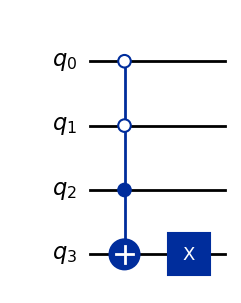

In [34]:
clause_test = {'x0' : True, 'x1' : True, 'x2' : False}

test_qc = QuantumCircuit(4)
disj_gate = logical_disjunction_to_gate(clause_test)
test_qc.append(disj_gate,range(4))
test_qc.decompose().draw('mpl')

# Construire l'oracle

In [40]:
# Créer des registres quantiques pour les variables et les clauses
var_qubits = QuantumRegister(nb_variables, name='x')
clause_qubits = QuantumRegister(nb_clauses, name='c')

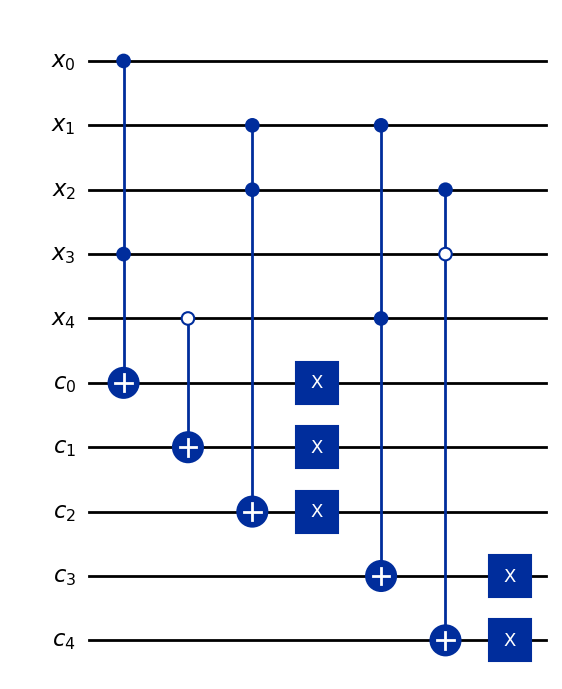

In [41]:
# Construire le circuit de clauses
clauses_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Ajouter chaque clause de disjonction comme une porte :

# Clause 0
for i in range(nb_clauses):
  # Convertir la première disjonction en porte
  gate = logical_disjunction_to_gate(clauses[i])
  # Sélectionner les qubits associés à la première clause
  c_qubits = get_disjunction_qubits(clauses[i], clause_qubits[i], var_qubits)
  # Ajouter la porte au circuit de clauses
  clauses_circuit.append(gate, c_qubits)


# P.S : vous pouvez utiliser des boucles si vous le désirez.

# Afficher le circuit :
clauses_circuit.decompose(gates_to_decompose=['mcx'], reps=2).draw(output='mpl')

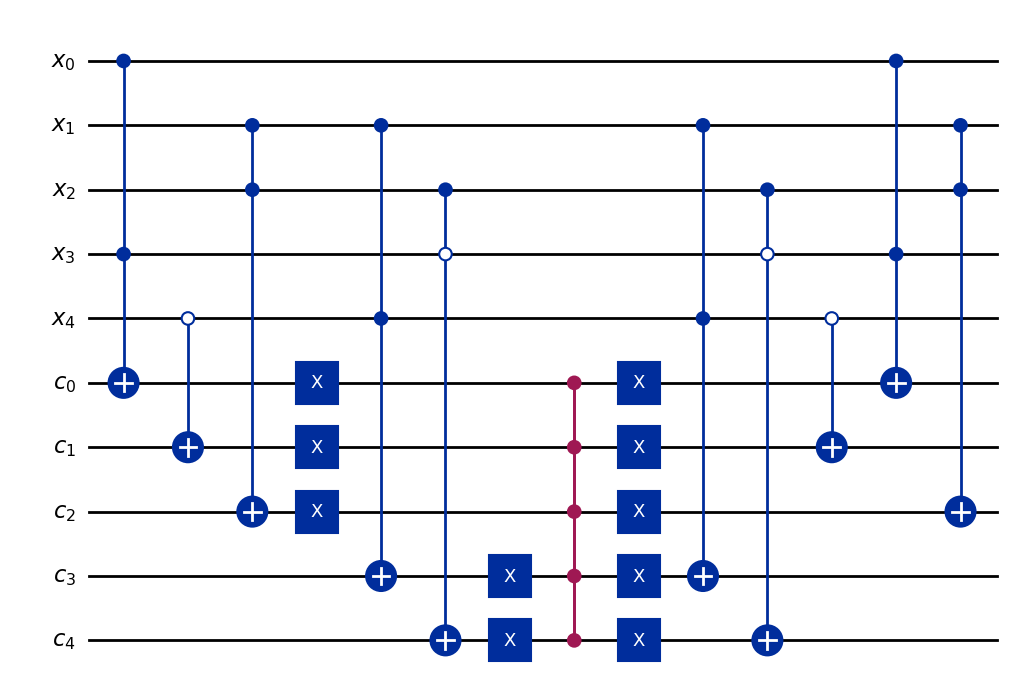

In [42]:
# Construire le circuit de l'oracle
oracle_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Ajouter le circuit de clauses
# --- la transformation vers une porte n'est utile qu'à des fins d'affichage plus tard ---
oracle_circuit.append(clauses_circuit.to_gate(label='clauses_circuit'), clauses_circuit.qubits)

# Ajouter la porte multi-controle Z
mc_z_gate = ZGate().control(nb_clauses - 1)
oracle_circuit.append(mc_z_gate, clause_qubits)

# Ajouter l'inverse du circuit de clauses
oracle_circuit.append(clauses_circuit.reverse_ops().to_gate(label='clauses_circuit'), oracle_circuit.qubits)

# Afficher le circuit
oracle_circuit.decompose(gates_to_decompose=['clauses_circuit', 'mcx'], reps=2).draw(output='mpl')


# Construire le diffuseur

Complétez le circuit du diffuseur.

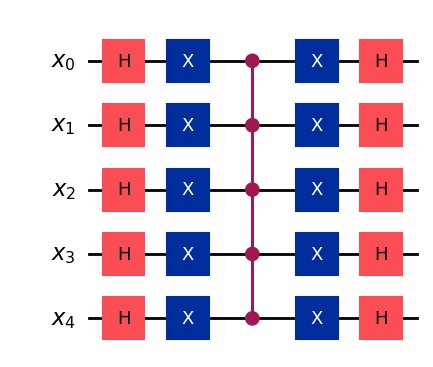

In [44]:
# Construire le circuit de diffuseur
diffuser_circuit = QuantumCircuit(var_qubits)

# Ajouter des portes H et X pour chaque qubit du diffuseur
diffuser_circuit.h(range(nb_variables))
diffuser_circuit.x(range(nb_variables))

# Ajouter une multi-controle Z
mc_z_gate = ZGate().control(nb_variables - 1)
diffuser_circuit.append(mc_z_gate, var_qubits)

# Ajouter des portes X et H pour chaque qubit du diffuseur
diffuser_circuit.x(range(nb_variables))
diffuser_circuit.h(range(nb_variables))

# Afficher le circuit
diffuser_circuit.draw(output='mpl')

# Assembler le circuit de Grover

Complétez le circuit de Grover.

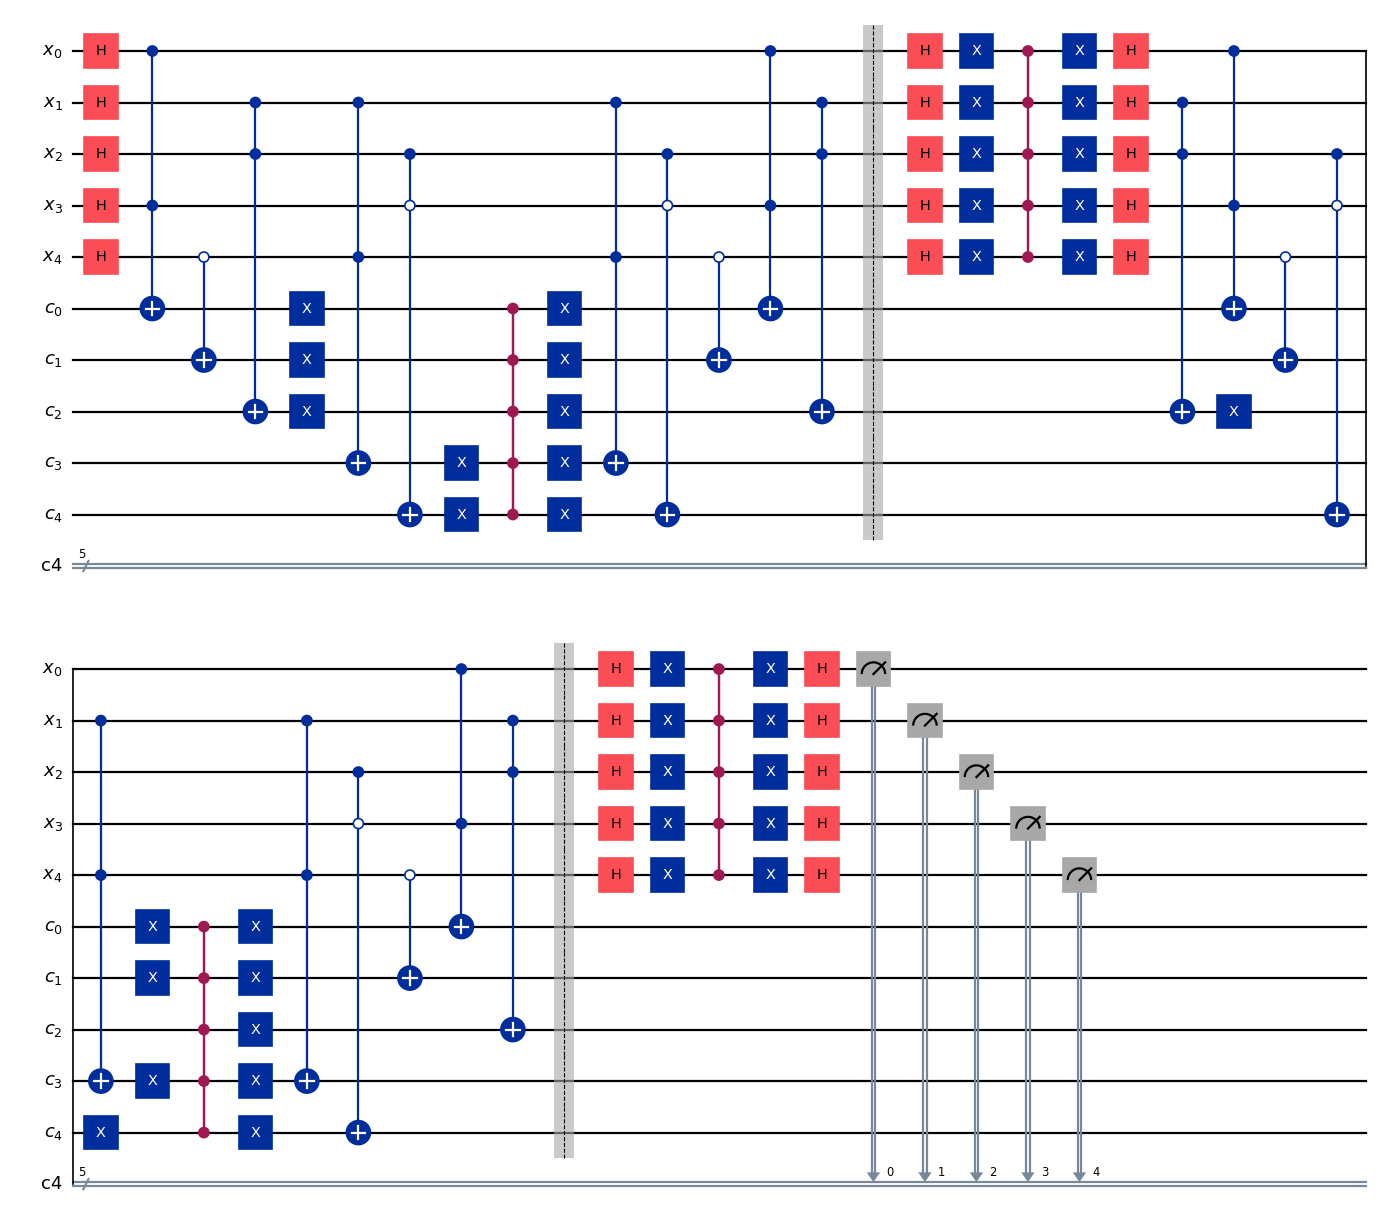

In [49]:
# Construire le circuit de Grover
c_bits = ClassicalRegister(nb_variables)
grover_circuit = QuantumCircuit(var_qubits, clause_qubits, c_bits)

# Ajouter des portes H pour chaque variable
grover_circuit.h(range(nb_variables))

# Identifier le nombre d'iterations
nb_iterations = 2 # Jouez avec le nombre d'itérations pour en voir l'effet

# Ajouter autant d'oracles et de diffuseurs qu'il y a de nombre d'itérations
for it in range(nb_iterations):
    grover_circuit.append(oracle_circuit.to_gate(label='oracle'), grover_circuit.qubits)
    grover_circuit.barrier(grover_circuit.qubits)
    grover_circuit.append(diffuser_circuit.to_gate(label='diffusor'), grover_circuit.qubits[0:nb_variables])

# Ajouter les mesures pour l'evaluation du circuit
grover_circuit.measure(var_qubits, c_bits)

# Afficher le circuit
grover_circuit.decompose(gates_to_decompose=['oracle', 'clauses_circuit', 'diffusor', 'mcx'], reps=3).draw(output='mpl',
                                                                                                   scale=0.8)

# Mesure de la solution

In [46]:
from qiskit_aer import AerSimulator
from qiskit import transpile

# Prepaper une simulation pour rouler et mesurer la solution
def run_circuit(circ: QuantumCircuit) -> dict:
    """
    Run a quantum circuit on the AerSimulator and return the counts
    @param circ: QuantumCircuit to run
    @return: dictionary of measurement results and their counts
    """
    simulator = AerSimulator()
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=10000).result()
    return result.get_counts(circ)

In [50]:

# Executer le circuit et obtenir le compte de solutions
counts = run_circuit(grover_circuit)

print(counts)

{'11101': 13, '11110': 21, '01101': 21, '10100': 16, '10111': 20, '11100': 2325, '10101': 18, '10010': 29, '01011': 18, '00111': 22, '00011': 25, '01110': 18, '10001': 2323, '00101': 19, '01001': 27, '11010': 11, '00100': 21, '11000': 2365, '10000': 2439, '11111': 26, '11011': 18, '10110': 19, '00001': 21, '00110': 11, '01000': 15, '01100': 22, '11001': 24, '00000': 17, '01010': 17, '10011': 18, '01111': 14, '00010': 27}


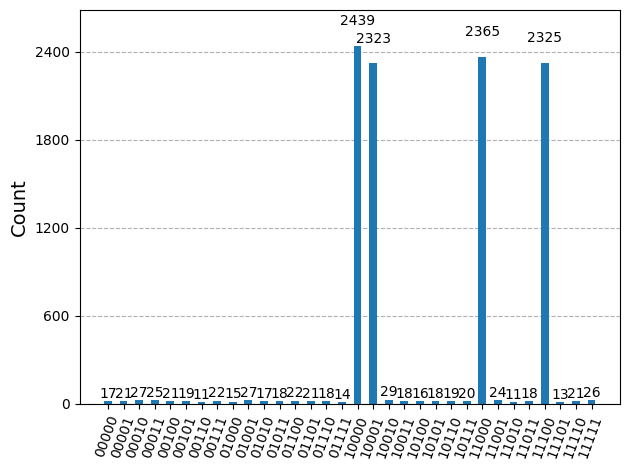

In [51]:
# Afficher l'histogramme de comptes
plot_histogram(counts)

Rappel :

* x0 = Peureux
* x1 = Heureux
* x2 = Malade
* x3 = Bruyant